## Image segmentation with SAM 3

This notebook demonstrates how to use SAM 3 for image segmentation with text or visual prompts. It covers the following capabilities:

- **Text prompts**: Using natural language descriptions to segment objects (e.g., "person", "face")
- **Box prompts**: Using bounding boxes as exemplar visual prompts

# <a target="_blank" href="https://colab.research.google.com/github/facebookresearch/sam3/blob/main/notebooks/sam3_image_predictor_example.ipynb">
#   <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
# </a>

In [1]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())


PyTorch version: 2.9.0+cu130
Torchvision version: 0.24.0+cu130
CUDA is available: True


In [2]:
import os
import warnings

# Suppress joblib/loky warning about physical cores on Windows
os.environ["LOKY_MAX_CPU_COUNT"] = str(os.cpu_count())

# Suppress deprecation warnings
warnings.filterwarnings("ignore", category=UserWarning, module="joblib")
warnings.filterwarnings("ignore", message=".*pkg_resources.*")

import matplotlib.pyplot as plt
import numpy as np

import sam3
from PIL import Image
from sam3 import build_sam3_image_model
from sam3.model.box_ops import box_xywh_to_cxcywh
from sam3.model.sam3_image_processor import Sam3Processor
from sam3.visualization_utils import draw_box_on_image, normalize_bbox, plot_results

sam3_root = os.path.dirname(sam3.__file__)
print(f"SAM3 root: {sam3_root}")

d:\miniconda3\Lib\site-packages\torch\backends\__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:85.)
  self.setter(val)
  File "d:\miniconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
  File "d:\miniconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
        "wmic C

SAM3 root: d:\miniconda3\Lib\site-packages\sam3


In [3]:
import torch
import warnings

# =============================================================================
# PRECISION CONFIG - Change this to switch between bfloat16 and float32
# =============================================================================
USE_BFLOAT16 = True # True = bfloat16 (faster, less memory), False = float32 (full precision)

# Suppress TF32 deprecation warning
warnings.filterwarnings("ignore", message=".*TF32.*")

# Enable TF32 for Ampere GPUs (PyTorch 2.9+ API)
if hasattr(torch.backends.cuda.matmul, 'fp32_precision'):
    # New API for PyTorch 2.9+
    torch.backends.cuda.matmul.fp32_precision = 'tf32'
    torch.backends.cudnn.conv.fp32_precision = 'tf32'
else:
    # Fallback for older PyTorch versions
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

# Apply precision setting
if USE_BFLOAT16:
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    print("Precision: bfloat16 (faster, ~50% less memory, <0.1% accuracy loss)")
else:
    print("Precision: float32 (full precision, slower, more memory)")

Precision: bfloat16 (faster, ~50% less memory, <0.1% accuracy loss)


# Build Model

In [4]:
# SAM3 is a gated model on HuggingFace (first time setup only)
# After first login & download, the model is cached locally and this cell can be skipped.
#
# First time setup:
# 1. Go to https://huggingface.co/facebook/sam3 and accept the license
# 2. Create a token at https://huggingface.co/settings/tokens
# 3. Run this cell once with your token

from huggingface_hub import login, get_token

# Check if already logged in
if get_token() is None:
    print("Not logged in. Please enter your HuggingFace token:")
    login(add_to_git_credential=True)  # Saves token permanently
else:
    print("Already logged in to HuggingFace. Token found.")

Already logged in to HuggingFace. Token found.


In [5]:
# Build the SAM3 model (will download from HuggingFace)
bpe_path = f"{sam3_root}/assets/bpe_simple_vocab_16e6.txt.gz"
model = build_sam3_image_model(bpe_path=bpe_path)

In [8]:
# Sample images in D:\SAM\samples folder:
# - D1.png, D2.png, D3.png, D4.png, D5.png, D6.png

image_path = r"D:\SAM\samples\Encoding_test\D8_1.png"  # Change to D2.png, D3.png, etc. to test other images

image = Image.open(image_path)

# Convert RGBA to RGB if needed (SAM3 expects 3 channels)
if image.mode == 'RGBA':
    # Create white background and paste image on it
    background = Image.new('RGB', image.size, (255, 255, 255))
    background.paste(image, mask=image.split()[3])  # Use alpha channel as mask
    image = background
elif image.mode != 'RGB':
    image = image.convert('RGB')

width, height = image.size
print(f"Image: {image_path}")
print(f"Image size: {width}x{height}")
print(f"Image mode: {image.mode}")



Image: D:\SAM\samples\Encoding_test\D8_1.png
Image size: 1351x1188
Image mode: RGB


# Text prompt

dict_keys(['original_height', 'original_width', 'backbone_out', 'geometric_prompt', 'masks_logits', 'masks', 'boxes', 'scores'])
found 5 object(s)
tensor([[1252.8608,  515.0477, 1296.5815,  559.2898],
        [1253.2261, 1092.1775, 1295.8339, 1136.0105],
        [1253.4272,  825.3398, 1295.8400,  869.3641],
        [  27.9943,  515.2542,   71.4246,  558.5508],
        [  43.0578,   57.7218,   85.8391,  100.2834]], device='cuda:0')


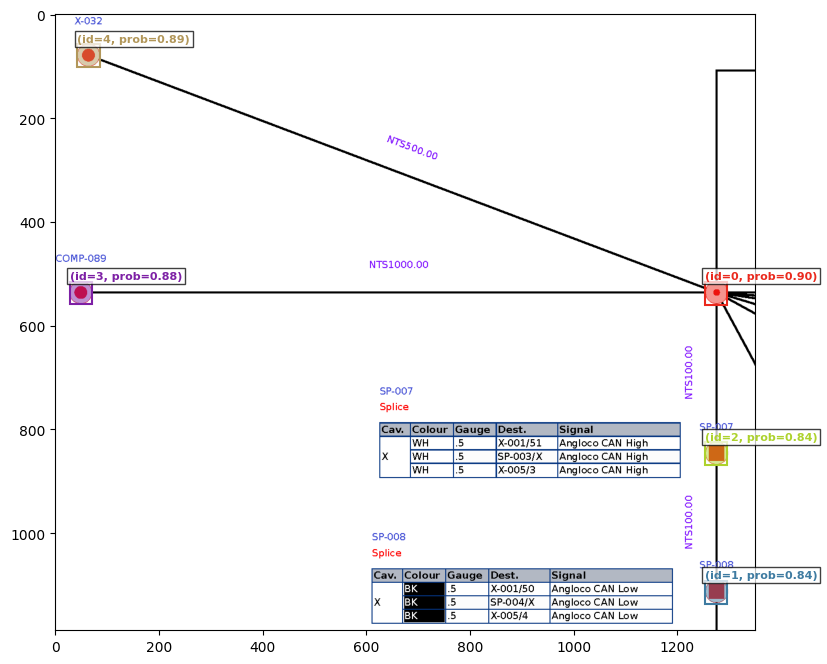

In [15]:

processor = Sam3Processor(model, confidence_threshold=0.750)
inference_state = processor.set_image(image)

processor.reset_all_prompts(inference_state)
inference_state = processor.set_text_prompt(state=inference_state, prompt="nodes ")  # Changed to "wire" for your schematic images

print(inference_state.keys())
img0 = Image.open(image_path)
plot_results(img0, inference_state)
print(inference_state["boxes"])

clamps
nodes
connectors
